In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression



In [ ]:
adi_god = pd.read_csv('imputed_city_hour_scaled.csv')

adi_god.shape

(286196, 16)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_absolute_error, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_absolute_error, confusion_matrix, classification_report
from torch.utils.data import DataLoader, TensorDataset

# Load the data
data = pd.read_csv("imputed_city_hour_scaled.csv")

# Preprocessing
data['City'] = LabelEncoder().fit_transform(data['City'])
data['Datetime'] = pd.to_datetime(data['Datetime'])
data['hour'] = data['Datetime'].dt.hour
data['month'] = data['Datetime'].dt.month
data['year'] = data['Datetime'].dt.year

# Grouped Train-Test Split for Time-Series Data
def time_series_split_by_city(data, test_ratio=0.2):
    train_data = pd.DataFrame()
    test_data = pd.DataFrame()

    for city in data['City'].unique():
        city_data = data[data['City'] == city].sort_values(by='Datetime')
        test_size = int(len(city_data) * test_ratio)
        train_data = pd.concat([train_data, city_data[:-test_size]])
        test_data = pd.concat([test_data, city_data[-test_size:]])

    return train_data, test_data

# Perform the split
train_data, test_data = time_series_split_by_city(data)

# Drop 'Datetime' after splitting
train_data = train_data.drop(columns=['Datetime'])
test_data = test_data.drop(columns=['Datetime'])

# Separate features and targets
X_train = train_data.drop(columns=['AQI', 'AQI_Bucket'])
y_reg_train = train_data['AQI']
y_clf_train = LabelEncoder().fit_transform(train_data['AQI_Bucket'])

X_test = test_data.drop(columns=['AQI', 'AQI_Bucket'])
y_reg_test = test_data['AQI']
y_clf_test = LabelEncoder().fit_transform(test_data['AQI_Bucket'])

# Normalize features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_reg_train_tensor = torch.tensor(y_reg_train.values, dtype=torch.float32)
y_clf_train_tensor = torch.tensor(y_clf_train, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_reg_test_tensor = torch.tensor(y_reg_test.values, dtype=torch.float32)
y_clf_test_tensor = torch.tensor(y_clf_test, dtype=torch.long)

# Create DataLoaders
batch_size = 1000
train_reg_loader = DataLoader(TensorDataset(X_train_tensor, y_reg_train_tensor), batch_size=batch_size, shuffle=True)
train_clf_loader = DataLoader(TensorDataset(X_train_tensor, y_clf_train_tensor), batch_size=batch_size, shuffle=True)

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Regression Model
class RegressionModel(nn.Module):
    def __init__(self, input_size):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Instantiate models
input_dim = X_train.shape[1]
num_classes = len(np.unique(y_clf_train))

reg_model = RegressionModel(input_dim).to(device)


# Optimizers and loss functions
reg_optimizer = optim.Adam(reg_model.parameters(), lr=0.01)


reg_criterion = nn.MSELoss()
clf_criterion = nn.CrossEntropyLoss()

# Train Regression Model
reg_model.train()
for epoch in range(200):  # Reduced epochs for demonstration
    epoch_loss = 0
    for X_batch, y_batch in train_reg_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        reg_optimizer.zero_grad()
        y_pred = reg_model(X_batch).squeeze()
        loss = reg_criterion(y_pred, y_batch)
        loss.backward()
        reg_optimizer.step()

        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}, Regression Loss: {epoch_loss/len(train_reg_loader)}")

# Evaluate Regression Model
reg_model.eval()
y_reg_pred = reg_model(X_test_tensor.to(device)).cpu().detach().numpy().squeeze()
print("MAE:", mean_absolute_error(y_reg_test, y_reg_pred))


cuda
Epoch 1, Regression Loss: 8846.681381558747
Epoch 2, Regression Loss: 4311.765081280704
Epoch 3, Regression Loss: 3996.563477628616
Epoch 4, Regression Loss: 3758.8926836705105
Epoch 5, Regression Loss: 3571.0647996127864
Epoch 6, Regression Loss: 3398.158863050969
Epoch 7, Regression Loss: 3314.8008004400926
Epoch 8, Regression Loss: 3278.3817144002455
Epoch 9, Regression Loss: 3253.731233155363
Epoch 10, Regression Loss: 3224.8826088717933
Epoch 11, Regression Loss: 3198.621529791553
Epoch 12, Regression Loss: 3115.9989616027565
Epoch 13, Regression Loss: 3042.6387294452784
Epoch 14, Regression Loss: 3003.7629367878344
Epoch 15, Regression Loss: 2963.332508870087
Epoch 16, Regression Loss: 2940.6268625051175
Epoch 17, Regression Loss: 2913.055891145265
Epoch 18, Regression Loss: 2883.666639303016
Epoch 19, Regression Loss: 2852.9691604547625
Epoch 20, Regression Loss: 2820.686908305472
Epoch 21, Regression Loss: 2784.1726202152704
Epoch 22, Regression Loss: 2768.432260571609
Epo

MAE: 26.014257817386984
R^2 Score: 0.7828859892501328


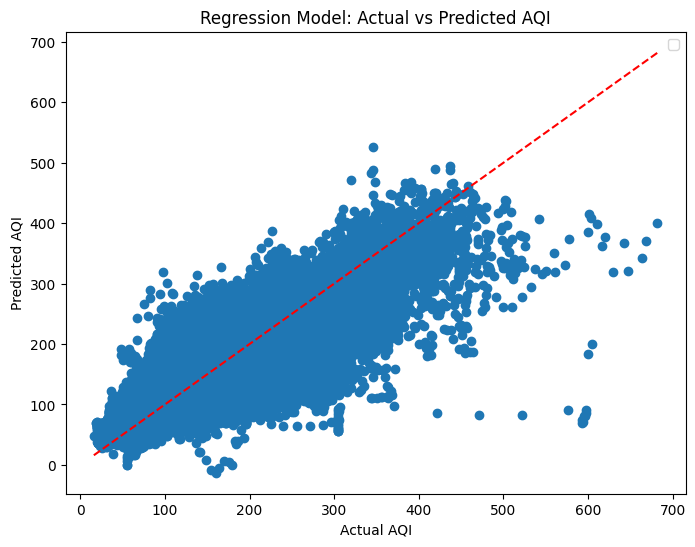

In [ ]:
# prompt: for both models draw grpahs and also print R2 score F1 etc. based on regression and classification metrics

from sklearn.metrics import r2_score, f1_score


# Evaluate Regression Model
reg_model.eval()
y_reg_pred = reg_model(X_test_tensor.to(device)).cpu().detach().numpy().squeeze()
mae = mean_absolute_error(y_reg_test, y_reg_pred)
r2 = r2_score(y_reg_test, y_reg_pred)
print("MAE:", mae)
print("R^2 Score:", r2)

plt.figure(figsize=(8, 6))
plt.scatter(y_reg_test, y_reg_pred)
plt.xlabel("Actual AQI")
plt.ylabel("Predicted AQI")
plt.title("Regression Model: Actual vs Predicted AQI")
plt.legend()
plt.plot([min(y_reg_test), max(y_reg_test)], [min(y_reg_test), max(y_reg_test)], color='red', linestyle='--')  # Add diagonal line
plt.show()



In [ ]:
# prompt: save above 2 models so i can load them

import torch

# Save the regression model
torch.save(reg_model.state_dict(), 'regression_model.pth')

# Save the classification model


In [ ]:
from sklearn.cluster import KMeans
import numpy as np

cpy = adi_god.copy()
#Label Encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
cpy['City'] = le.fit_transform(cpy['City'])
cpy['Datetime'] = le.fit_transform(cpy['Datetime'])
cpy["AQI_Bucket"] = le.fit_transform(cpy["AQI_Bucket"])
# Assuming `data` is a NumPy array
kmeans = KMeans(n_clusters=10000, random_state=42)
kmeans.fit(cpy)
reduced_data = kmeans.cluster_centers_  # Cluster centroids as reduced data


In [ ]:

cpy['City'] = LabelEncoder().fit_transform(cpy['City'])
cpy['Datetime'] = pd.to_datetime(cpy['Datetime'])
cpy['hour'] =  cpy['Datetime'].dt.hour
cpy['month'] = cpy['Datetime'].dt.month
cpy['year'] =   cpy['Datetime'].dt.year

# Perform the split
train_data, test_data = time_series_split_by_city(cpy)

# Drop 'Datetime' after splitting
train_data = train_data.drop(columns=['Datetime'])
test_data = test_data.drop(columns=['Datetime'])

# Separate features and targets
X_train = train_data.drop(columns=['AQI', 'AQI_Bucket'])
y_reg_train = train_data['AQI']
y_clf_train = LabelEncoder().fit_transform(train_data['AQI_Bucket'])

X_test = test_data.drop(columns=['AQI', 'AQI_Bucket'])
y_reg_test = test_data['AQI']
y_clf_test = LabelEncoder().fit_transform(test_data['AQI_Bucket'])

# Normalize features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_reg_train_tensor = torch.tensor(y_reg_train.values, dtype=torch.float32)
y_clf_train_tensor = torch.tensor(y_clf_train, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_reg_test_tensor = torch.tensor(y_reg_test.values, dtype=torch.float32)
y_clf_test_tensor = torch.tensor(y_clf_test, dtype=torch.long)

# Create DataLoaders
batch_size = 1000
train_reg_loader = DataLoader(TensorDataset(X_train_tensor, y_reg_train_tensor), batch_size=batch_size, shuffle=True)
train_clf_loader = DataLoader(TensorDataset(X_train_tensor, y_clf_train_tensor), batch_size=batch_size, shuffle=True)

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Instantiate models
input_dim = X_train.shape[1]
num_classes = len(np.unique(y_clf_train))

reg_model = RegressionModel(input_dim).to(device)


# Optimizers and loss functions
reg_optimizer = optim.Adam(reg_model.parameters(), lr=0.01)

reg_criterion = nn.MSELoss()


# Train Regression Model
reg_model.train()
for epoch in range(500):  # Reduced epochs for demonstration
    epoch_loss = 0
    for X_batch, y_batch in train_reg_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        reg_optimizer.zero_grad()
        y_pred = reg_model(X_batch).squeeze()
        loss = reg_criterion(y_pred, y_batch)
        loss.backward()
        reg_optimizer.step()

        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}, Regression Loss: {epoch_loss/len(train_reg_loader)}")

# Evaluate Regression Model
reg_model.eval()
y_reg_pred = reg_model(X_test_tensor.to(device)).cpu().detach().numpy().squeeze()
print("MAE:", mean_absolute_error(y_reg_test, y_reg_pred))


cuda
Epoch 1, Regression Loss: 5462.230219439941
Epoch 2, Regression Loss: 4188.607703839508
Epoch 3, Regression Loss: 3910.1199207063323
Epoch 4, Regression Loss: 3723.32560908053
Epoch 5, Regression Loss: 3610.783855412108
Epoch 6, Regression Loss: 3515.0201441862796
Epoch 7, Regression Loss: 3438.6346310149697
Epoch 8, Regression Loss: 3381.813632933632
Epoch 9, Regression Loss: 3336.660273278834
Epoch 10, Regression Loss: 3286.0369878378388
MAE: 30.462793794588045
Epoch 1, Classification Loss: 1.5486012819678028
Epoch 2, Classification Loss: 1.535083867285653
Epoch 3, Classification Loss: 1.5319782869704197
Epoch 4, Classification Loss: 1.5293367554473343
Epoch 5, Classification Loss: 1.5268290426912714
Epoch 6, Classification Loss: 1.5253095775780188
Epoch 7, Classification Loss: 1.5242060085179339
Epoch 8, Classification Loss: 1.5234380910314937
Epoch 9, Classification Loss: 1.5227193908871344
Epoch 10, Classification Loss: 1.5218570256549775
Confusion Matrix:
[[    0    44     0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:

# save the model to disk
import pickle
filename = 'kmeans_model.sav'
pickle.dump(kmeans, open(filename, 'wb'))

#also save the centeres
filename = 'kmeans_centers.sav'
pickle.dump(reduced_data, open(filename, 'wb'))



In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Read the CSV file and convert 'Datetime' to datetime format
df = pd.read_csv('imputed_city_hour_scaled.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Encode 'City' and 'AQI_Bucket' columns
le_city = LabelEncoder()
le_aqi = LabelEncoder()
df['City'] = le_city.fit_transform(df['City'])
df['AQI_Bucket'] = le_aqi.fit_transform(df['AQI_Bucket'])

# Resample the data by 'Datetime' (daily frequency) and calculate the mean for each city
df_resampled = (
    df.set_index('Datetime')
    .groupby('City')   # Group by City
    .resample('D')     # Resample by day
    .median()
      # Reset only 'Datetime' to a column
)
df_resampled['City'] = le_city.fit_transform(df_resampled['City'])
df_resampled['AQI_Bucket'] = le_aqi.fit_transform(df_resampled['AQI_Bucket'])

# Print the shape of the resampled DataFrame
print(df_resampled.shape)


(14322, 15)


In [ ]:
print(df_resampled.columns)

Index(['City', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3',
       'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket'],
      dtype='object')


In [ ]:
print(set(df_resampled["AQI_Bucket"]))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}


In [ ]:

df_resampled['City'] = LabelEncoder().fit_transform(df_resampled['City'])
# # df_resampled['Datetime'] = pd.to_datetime(df_resampled['Datetime'])
# df_resampled['hour'] =  df_resampled['Datetime'].dt.hour
# df_resampled['month'] = df_resampled['Datetime'].dt.month
# df_resampled['year'] =   df_resampled['Datetime'].dt.year

# Perform the split
train_data, test_data = time_series_split_by_city(df_resampled)

# Drop 'Datetime' after splitting
# train_data = train_data.drop(columns=['Datetime'])
# test_data = test_data.drop(columns=['Datetime'])

# Separate features and targets
X_train = train_data.drop(columns=['AQI', 'AQI_Bucket'])
y_reg_train = train_data['AQI']
y_clf_train = LabelEncoder().fit_transform(train_data['AQI_Bucket'])

X_test = test_data.drop(columns=['AQI', 'AQI_Bucket'])
y_reg_test = test_data['AQI']
y_clf_test = LabelEncoder().fit_transform(test_data['AQI_Bucket'])

# Normalize features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_reg_train_tensor = torch.tensor(y_reg_train.values, dtype=torch.float32)
y_clf_train_tensor = torch.tensor(y_clf_train, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_reg_test_tensor = torch.tensor(y_reg_test.values, dtype=torch.float32)
y_clf_test_tensor = torch.tensor(y_clf_test, dtype=torch.long)

# Create DataLoaders
batch_size = 32
train_reg_loader = DataLoader(TensorDataset(X_train_tensor, y_reg_train_tensor), batch_size=batch_size, shuffle=True)
train_clf_loader = DataLoader(TensorDataset(X_train_tensor, y_clf_train_tensor), batch_size=batch_size, shuffle=True)

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Instantiate models
input_dim = X_train.shape[1]
num_classes = len(np.unique(y_clf_train))

reg_model = RegressionModel(input_dim).to(device)
clf_model = ClassificationModel(input_dim, num_classes).to(device)

# Optimizers and loss functions
reg_optimizer = optim.Adam(reg_model.parameters(), lr=0.001)
clf_optimizer = optim.Adam(clf_model.parameters(), lr=0.001)

reg_criterion = nn.MSELoss()
clf_criterion = nn.CrossEntropyLoss()

# Train Regression Model
reg_model.train()
for epoch in range(10):  # Reduced epochs for demonstration
    epoch_loss = 0
    for X_batch, y_batch in train_reg_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        reg_optimizer.zero_grad()
        y_pred = reg_model(X_batch).squeeze()
        loss = reg_criterion(y_pred, y_batch)
        loss.backward()
        reg_optimizer.step()

        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}, Regression Loss: {epoch_loss/len(train_reg_loader)}")

# Evaluate Regression Model
reg_model.eval()
y_reg_pred = reg_model(X_test_tensor.to(device)).cpu().detach().numpy().squeeze()
print("MAE:", mean_absolute_error(y_reg_test, y_reg_pred))

# Train Classification Model
clf_model.train()
for epoch in range(10):  # Reduced epochs for demonstration
    epoch_loss = 0
    for X_batch, y_batch in train_clf_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        clf_optimizer.zero_grad()
        y_pred = clf_model(X_batch)
        loss = clf_criterion(y_pred, y_batch)
        loss.backward()
        clf_optimizer.step()

        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}, Classification Loss: {epoch_loss/len(train_clf_loader)}")

# Evaluate Classification Model
clf_model.eval()
y_clf_pred = torch.argmax(clf_model(X_test_tensor.to(device)), dim=1).cpu().numpy()
print("Confusion Matrix:")
print(confusion_matrix(y_clf_test, y_clf_pred))
print("Classification Report:")
print(classification_report(y_clf_test, y_clf_pred))


cuda
Epoch 1, Regression Loss: nan
Epoch 2, Regression Loss: nan
Epoch 3, Regression Loss: nan
Epoch 4, Regression Loss: nan
Epoch 5, Regression Loss: nan
Epoch 6, Regression Loss: nan


KeyboardInterrupt: 

In [ ]:
from scipy.signal import find_peaks
df = pd.read_csv('imputed_city_hour_scaled.csv')
# Detect peaks in PM2.5 for each city
for city in df['City'].unique():
    city_data = df[df['City'] == city]
    peaks, _ = find_peaks(city_data['PM2.5'], height=0.01)  # Example threshold

    # Keep only rows corresponding to the peaks
    df_peaks = city_data.iloc[peaks]

print(df_peaks.head())
print(df_peaks.shape)

                 City             Datetime     PM2.5      PM10        NO  \
252400  Visakhapatnam  2016-07-03 08:00:00  0.163051  0.236337  0.105099   
252476  Visakhapatnam  2016-07-06 12:00:00  0.066990  0.169604  0.090281   
252486  Visakhapatnam  2016-07-06 22:00:00  0.119116  0.250545  0.241659   
252489  Visakhapatnam  2016-07-07 01:00:00  0.134009  0.262600  0.093007   
252498  Visakhapatnam  2016-07-07 10:00:00  0.092556  0.169820  0.156749   

             NO2       NOx       NH3        CO       SO2        O3   Benzene  \
252400  0.561341  0.241930  0.263279  0.049582  0.242814  0.247320  0.138801   
252476  0.293213  0.146271  0.159891  0.029124  0.136797  0.263124  0.059709   
252486  0.555793  0.317367  0.119808  0.042225  0.063264  0.096815  0.141718   
252489  0.397895  0.180965  0.107343  0.028419  0.047886  0.152702  0.085500   
252498  0.404378  0.220241  0.094910  0.022070  0.021979  0.190745  0.078466   

         Toluene    Xylene   AQI    AQI_Bucket  
252400  0.183

In [ ]:

df_peaks['City'] = LabelEncoder().fit_transform(df_peaks['City'])
df_peaks['Datetime'] = pd.to_datetime(df_peaks['Datetime'])
df_peaks['hour'] =  df_peaks['Datetime'].dt.hour
df_peaks['month'] = df_peaks['Datetime'].dt.month
df_peaks['year'] =   df_peaks['Datetime'].dt.year

# Perform the split
train_data, test_data = time_series_split_by_city(df_peaks)

# Drop 'Datetime' after splitting
train_data = train_data.drop(columns=['Datetime'])
test_data = test_data.drop(columns=['Datetime'])

# Separate features and targets
X_train = train_data.drop(columns=['AQI', 'AQI_Bucket'])
y_reg_train = train_data['AQI']
y_clf_train = LabelEncoder().fit_transform(train_data['AQI_Bucket'])

X_test = test_data.drop(columns=['AQI', 'AQI_Bucket'])
y_reg_test = test_data['AQI']
y_clf_test = LabelEncoder().fit_transform(test_data['AQI_Bucket'])

# Normalize features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_reg_train_tensor = torch.tensor(y_reg_train.values, dtype=torch.float32)
y_clf_train_tensor = torch.tensor(y_clf_train, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_reg_test_tensor = torch.tensor(y_reg_test.values, dtype=torch.float32)
y_clf_test_tensor = torch.tensor(y_clf_test, dtype=torch.long)

# Create DataLoaders
batch_size = 1000
train_reg_loader = DataLoader(TensorDataset(X_train_tensor, y_reg_train_tensor), batch_size=batch_size, shuffle=True)

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Instantiate models
input_dim = X_train.shape[1]
num_classes = len(np.unique(y_clf_train))

reg_model = RegressionModel(input_dim).to(device)

# Optimizers and loss functions
reg_optimizer = optim.Adam(reg_model.parameters(), lr=0.01)
reg_criterion = nn.MSELoss()

# Train Regression Model
reg_model.train()
for epoch in range(600):  # Reduced epochs for demonstration
    epoch_loss = 0
    for X_batch, y_batch in train_reg_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        reg_optimizer.zero_grad()
        y_pred = reg_model(X_batch).squeeze()
        loss = reg_criterion(y_pred, y_batch)
        loss.backward()
        reg_optimizer.step()

        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}, Regression Loss: {epoch_loss/len(train_reg_loader)}")

# Evaluate Regression Model
reg_model.eval()
y_reg_pred = reg_model(X_test_tensor.to(device)).cpu().detach().numpy().squeeze()
print("MAE:", mean_absolute_error(y_reg_test, y_reg_pred))


<ipython-input-30-6768b5e23b20>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_peaks['City'] = LabelEncoder().fit_transform(df_peaks['City'])
<ipython-input-30-6768b5e23b20>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_peaks['Datetime'] = pd.to_datetime(df_peaks['Datetime'])
<ipython-input-30-6768b5e23b20>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

cuda
Epoch 1, Regression Loss: 16346.288736979166
Epoch 2, Regression Loss: 16192.362955729166
Epoch 3, Regression Loss: 15991.989908854166
Epoch 4, Regression Loss: 15532.526692708334
Epoch 5, Regression Loss: 14795.688151041666
Epoch 6, Regression Loss: 13589.9072265625
Epoch 7, Regression Loss: 11862.582682291666
Epoch 8, Regression Loss: 9626.330729166666
Epoch 9, Regression Loss: 7010.142252604167
Epoch 10, Regression Loss: 4440.266031901042
Epoch 11, Regression Loss: 2738.440673828125
Epoch 12, Regression Loss: 2672.5016276041665
Epoch 13, Regression Loss: 3483.0347493489585
Epoch 14, Regression Loss: 3367.3167317708335
Epoch 15, Regression Loss: 2689.7418619791665
Epoch 16, Regression Loss: 2313.108642578125
Epoch 17, Regression Loss: 2369.2186686197915
Epoch 18, Regression Loss: 2467.3595377604165
Epoch 19, Regression Loss: 2441.1741536458335
Epoch 20, Regression Loss: 2305.1221516927085
Epoch 21, Regression Loss: 2185.430948893229
Epoch 22, Regression Loss: 2133.0746256510415


MAE: 25.336378675518613
R^2 Score: 0.5316445408487983


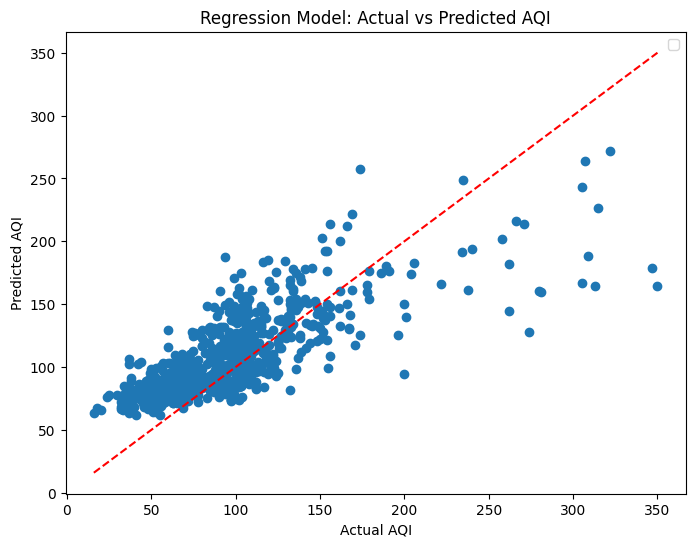

In [ ]:
# prompt: for both models draw grpahs and also print R2 score F1 etc. based on regression and classification metrics

from sklearn.metrics import r2_score, f1_score


# Evaluate Regression Model
reg_model.eval()
y_reg_pred = reg_model(X_test_tensor.to(device)).cpu().detach().numpy().squeeze()
mae = mean_absolute_error(y_reg_test, y_reg_pred)
r2 = r2_score(y_reg_test, y_reg_pred)
print("MAE:", mae)
print("R^2 Score:", r2)

plt.figure(figsize=(8, 6))
plt.scatter(y_reg_test, y_reg_pred)
plt.xlabel("Actual AQI")
plt.ylabel("Predicted AQI")
plt.title("Regression Model: Actual vs Predicted AQI")
plt.legend()
plt.plot([min(y_reg_test), max(y_reg_test)], [min(y_reg_test), max(y_reg_test)], color='red', linestyle='--')  # Add diagonal line
plt.show()

